## PA4 - Multiclass Learning

In this exercise you are required to design, implement, train, and test multiclass learning algorithms for the [MNIST](http://yann.lecun.com/exdb/mnist) dataset of images and the [20 Newsgroups](http://qwone.com/~jason/20Newsgroups) dataset of text news data. You will explore two different approaches to multiclass learning: *Cross Entropy*, a general loss appropriate for multiple classes, and *One-vs-All*, a reduction scheme from binary classification.

In [1]:
# Make sure to have the packages numpy, scikit-learn, and Tensorflow
# installed before starting the assignment

# import numpy first
import numpy as np

## The Losses

In the case of Cross Entropy, denoted in short as **CE**, the supervision for an example $\mathbf{x}\in\mathbb{R}^d$  is, instead of a label
$y\in[k]\stackrel{\tiny \mathsf{def}}{=}\{1,\ldots,k\}$, a vector $\mathbf{y}\in\Delta^k$ where
$$\Delta^k = \big\{\mathbf{p}=(p_1,\ldots,p_k)\, \big| \, \sum_i p_i = 1
   \mbox{ and } \forall i: p_i \geq 0 \big\} ~.$$
$\Delta^k$ is called the k$^{th}$ dimensional simplex and, informally speaking, it consists of all probability vectors in $\mathbb{R}^k$. The CE loss for a target probability vector $\mathbf{y}$ and predicted probability vector $\mathbf{\hat{y}}$ is defined as follows,
   $$\ell_{CE}(\mathbf{y, \hat{y}}) \stackrel{\tiny \mathsf{def}}{=}
     \sum_{i=1}^k y[i] \log\left(\frac{y[i]}{\hat{y}[i]}\right) ~ .$$
We use the convention that $0\log(0)\stackrel{\tiny \mathsf{def}}{=} 0$. To obtain the vector $\mathbf{\hat{y}}$ we exponentiate the vector of predictions $\mathbf{z} = W\mathbf{x} \in \mathbb{R}^k$ where $\mathbf{\hat{y}}[i] = \frac{\exp({\mathbf{z}[i]})}{Z}$ for all $i \in [k]$ and $Z$ ensures that $\mathbf{\hat{y}}\in \Delta^k $.

The One-vs-All, or **OvA**, approach instead uses $k$ logistic binary classifiers: the idea is to pick the label that has been *most confidently* chosen for the given example versus the rest. Formally, the loss can be expressed as follows. Given $(\mathbf{x},y)\in\mathbb{R}^d\times[k]$ let us define $\mathbf{\bar{y}}\in\{-1,1\}^k$ as the vector of labels resulting from the multiclass reduction. That is, $\mathbf{\bar{y}}[y]=1$ and for all $j\neq y$ we set $\mathbf{\bar{y}}[j]=-1$. Then the loss for $(\mathbf{x},y)$, with $\mathbf{z}$ defined as before, is
$$
\ell_{OvA}(\mathbf{\bar{y}}, \mathbf{z}) = \sum_{j=1}^k \log\big(1+ e^{-\mathbf{\bar{y}}[j] \, \mathbf{z}[j]}\big) ~ .
$$

ACT 1: Compute the value of $Z$ explicitly. Propose a method of computing $\mathbf{\hat{y}}$ from $\mathbf{z}$ that is numerically stable.

###

### ACT 1

recall $\mathbf{z} = W\mathbf{x} \in \mathbb{R}^k$

   $$ Z = \sum_{i=1}^k e^{z[i]} $$
   
   $$ \mathbf{\hat{y}}[i] = \frac{e^{\mathbf{z}[i]}}{\sum_{i=1}^k e^{\mathbf{z}[i]}}$$
   
Two problems:

(1) if all the z-values are <<0, then the summation in the denominator approaches zero. If underflow occurs, where they all get rounded to 0, this will cause an error when dividing by 0.

(2) If a single z-value is >>0, the value will be rounded to infinity, overflow will occur

Fix this problem by adding a scalar $(c = -max_i(\mathbf{z}))$ to the z-vector. This does not change the actual calculation:

$$ \frac{e^{\mathbf{z}[i] + c}}{\sum_{i=1}^k e^{\mathbf{z}[i] + c}} = \frac{e^{\mathbf{z}[i]}\cdot e^c }{\sum_{i=1}^k e^{\mathbf{z}[i]} \cdot e^c  }  $$

By shifting the z-vector by its max value, it is guaranteed that at least one of the terms will now be 0. And that 0 is the largest number in the z-vector. This fixes the problems above:

(1) If one term is 0, then e^0 = 1, and there will never be a 0 in the denominator.

(2) Since the largest term is 0, there is no chance of an exceptionally large exponent overflowing.

###


Let $X \in \mathbb{R}^{n \times d}$ be the given dataset and $\mathbf{y} \in [k]^n$ the corresponding labels. Construct one-hot vectors for each label to have a probability vector from $\Delta^k$: the one-hot vector for the class $c \in [k]$ if defined as $\mathbf{1}_c \in \Delta^k$ which is a vector of zeros except for coordinate $c$ where it is $1$. For example, suppose $k=4$ and $c=2$, then $\mathbf{1}_c$ is $(0, 1, 0, 0)$. When needed we will
be smoothing the one-hot vectors for numerical purposes. The $\epsilon$-smoothed one-hot vector for class $c$ is given by $(1-\epsilon) \mathbf{1}_c + \epsilon \mathbf{\frac1k}$ where $\mathbf{\frac1k} \in \Delta^k$ is the uniform probability vector, namely $\mathbf{\frac1k} = (\frac1k, \frac1k, \ldots, \frac1k)$.

ACT 2: Implement the `one_hot` function that given $\mathbf{y} \in [k]^n$ data of labels returns $Y \in \mathbb{R}^{n \times k}$ matrix of one-hot vectors. **In the code, the labels $\mathbf{y}$ are $0$-indexed, so you need to adjust accordingly.**

In [120]:
# Given y vector of labels, return matrix Y whose i-th row is the one-hot vector of label y_i 
# If eps is not 0, then need to compute the smoothed one-hot vectors instead
# If k is 0, then need to infer its value instead
def one_hot(y, k=0, eps=0):
    ### ACT 2
    
    if not k:
        k = y.max()+1
        
    Y = np.zeros((y.size, k))
    Y[np.arange(y.size),y] = 1

    if eps: 
        Y_bool = Y!=0
        Y[Y_bool] += -eps + eps/k
        Y[~Y_bool] += eps/k
   
    return Y
  

#ASSERTS
y_assert = np.array([3, 1, 0, 2, 1, 2])

Y_out = one_hot(y_assert)
assert(np.shape(Y_out) == (6,4))
assert(Y_out[0][3] == 1)
assert(sum(sum(Y_out)) == 6)

Y_out = one_hot(y_assert, 0, 0.1)
assert(Y_out[1][1] == 0.925)
assert(sum(sum(Y_out)) == 6.0)

Y_out = one_hot(y_assert, 10, 0.1)
assert(np.shape(Y_out) == (6,10))
assert(np.isclose(sum(sum(Y_out)),6.0))
assert(Y_out[0][5] == 0.01)
assert(Y_out[1][1] == 0.91)

y_assert = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 0, 1, 1, 1, 2, 2])
Y_out = one_hot(y_assert,[], 0.1)

You will first implement an abstract class for losses in general that has all the methods implemented except computing the loss value and the gradient. Then each of CE and OvA classes will implement their specific loss functions, and gradients separately. *Feel free to add your own methods to the class skeletons provided.*

It is worth to note that label prediction in both cases is done by predicting the coordinate with the largest value in the vector $\mathbf{z}$ as the label. In order to prevent the parameters from blowing up during training, we will implement methods `RowNorms` and `Project` to compute the norms of the rows of $W \in \mathbb{R}^{k \times d}$ and their projections onto the sphere of radius $r$.

ACT 3: Given a vector $\mathbf{v} \in \mathbb{R}^d$, compute its projection onto the sphere $S_r = \{ \mathbf{u} \in \mathbb{R}^d \, : \, \| \mathbf{u} \| \leq r \}$.

###

### ACT 3

if $ ||\mathbf{v}|| > r $ then the projection on sphere is found when $\mathbf{v}$ is projected onto $\mathbf{u}$, which is a vector from the center to the surface of the sphere chosen to minimize $||\mathbf{v} - \mathbf{u}||$.

This minimum is achieved by the vector that is in the same direction as $\mathbf{v}$, hence the projection on the sphere is just a scaling of the ratios of these vectors.

$$ \mathbf{v}_{proj}= \frac{r}{||\mathbf{v}||} \cdot \mathbf{v} $$

###

In [29]:
import copy

class GenericLoss:
    def __init__(self, name="", dims = [], W0 = []):
        self.name = name
        assert dims != [] or len(W0) != 0, 'Must set dims or W0'
        
        if len(W0) == 0:
            self.W = np.zeros(dims)
        else:
            self.W = W0
            
        self.k, self.d = self.W.shape
        
        #Added variables
        self.norms = np.zeros(self.k)

    
    # set the parameter matrix to the given W
    def Set(self, W):
        ### ACT 4
        self.W = copy.deepcopy(W)
    
    # get the parameter matrix of the instance
    def Get(self):
        ### ACT 5
        return self.W
    
    # update the parameter matrix by adding given dW
    def Update(self, dW):
        ### ACT 6
        self.W += dW
    
    # compute the norms of the rows of the parameter matrix
    def RowNorms(self):
        ### ACT 7
        return np.linalg.norm(self.W, axis=1)
        
    # compute the projection of each of the rows to the sphere of radius rad
    def Project(self, rad):
        ### ACT 8
        norms = self.RowNorms()
        
        scale = rad/norms
        scale = np.where(scale>1,1,scale)
        
        self.W = (self.W.T*scale).T

    # compute the numerical predictions (z values) given a data matrix X
    def Predict(self, X):
        ### ACT 9
        return np.dot(self.W,X.T).T

    # compute the label predictions given a data matrix X
    def PredictLabels(self, X):
        ### ACT 10
        zs = self.Predict(X) # Calculate z-values
        return np.argmax(zs,axis=1)
        
    # compute the classification error given a data matrix X, and label vector y
    def Error(self, X, y):
        ### ACT 11
        y_label_pred = self.PredictLabels(X)
        
        n = len(y)
        n_true = np.count_nonzero(y == y_label_pred)
        
        return (n - n_true)/n
        
    def Loss(self, X, y):
        pass
    
    def Gradient(self, X, y):
        pass
    
### ASSERTS
w = np.array([[1, 0, 0, 1], [2, 3, 1, 1], [1, 2, 2, 2]])
L = GenericLoss("assert_test",W0 = w)
assert(np.all(L.W == w))
L = GenericLoss("assert_test",(3,4),[])

#Set Function
L.Set(w)
assert(np.all(L.W == w))

#Update Function
L.Update(np.array([[0, 0, 1, 0], [0, 1, 1, 0], [0, 0, 0, 1]]))
assert(L.W[0][2] == (w[0][2] + 1))

#Norm Function
L.Set(w)
norms = L.RowNorms()
assert(norms[0] == np.sqrt(2))

L.Update(np.array([[0, 0, 1, 0], [0, 1, 1, 0], [0, 0, 0, 1]]))
norms = L.RowNorms()
assert(norms[1] == np.sqrt(25))

#Project Function
rad = 3.0
L.Set(w)
L.Project(rad)
norms = L.RowNorms()
assert(norms[0] == np.sqrt(2))
assert(norms[1] == rad)

#Predict Function
L.Set(w)
X = np.array([[1, 1, 1, 1], [0, 0, 1, 3]])
zs = L.Predict(X)
assert(np.shape(zs) == (2,3))
assert(zs[0][0] == 2)

#Predict Labels Function
L.Set(w)
X = np.array([[1, 1, 1, 2], [0, 0, 1, 3], [3, 0, -1, 1]])
y_label_pred = L.PredictLabels(X)
assert(y_label_pred[1] == 2)

#Errors Function
L.Set(w)
X = np.array([[1, 1, 1, 2], [0, 0, 1, 3], [3, 0, -1, 1]])
y = np.array([2,1,1])
error = L.Error(X,y)
assert(error == 1/3)


del(L)


To implement the specific losses, you simply need to compute the loss value itself given $X \in \mathbb{R}^{n \times d}, \mathbf{y} \in [k]^n$ and the parameter matrix $W \in \mathbb{R}^{k \times d}$ as well as the gradient of that loss with respect to $W$. Let us first express $\ell^{\mathsf{CE}}$ and $\ell^{\mathsf{OvA}}$ in terms of $X, \mathbf{y}, W$.

$$\ell^{\mathsf{CE}}(X, \mathbf{y}, W) = \frac{1}{n} \sum_{i=1}^n \ell_{CE}(\mathbf{y}_i, \hat{\mathbf{y}}_i), \quad \ell^{\mathsf{OvA}}(X, \mathbf{y}, W) = \frac{1}{n} \sum_{i=1}^n \ell_{OvA}(\bar{\mathbf{y}}_i, \mathbf{z}_i) ~ .$$

where for each $i \in [n]$ the vectors $\mathbf{y}_i$ are the rows of $Y =$ `one_hot`$(\mathbf{y}) \in \mathbb{R}^{n \times k}$, $\bar{\mathbf{y}}_i$ are the rows of $\bar{Y} = (2Y - 1) \in \mathbb{R}^{n \times k}$, $\mathbf{z}_i$ are the rows of $\mathbf{Z} = X W^{\top} \in \mathbb{R}^{n \times d}$, and $\hat{\mathbf{y}}_i = \exp(\mathbf{z}_i)/Z_i$ with $Z_i$ making sure $\hat{\mathbf{y}}_i \in \Delta^k$. The gradient computation can be done step-by-step using the chain rule.

ACT 12: Compute the gradient of $\ell^{\mathsf{CE}}$ w.r.t. $W$, given by $\nabla_W \ell^{\mathsf{CE}}$.

Hint: First, show for a single $\mathbf{y}, \mathbf{\hat{y}}, \mathbf{z}$ that $\nabla_{\mathbf{z}} \ell_{CE}(\mathbf{y}, \mathbf{\hat{y}}) = \mathbf{\hat{y}} - \mathbf{y}$ (simplify the loss function explicitly in terms of $\mathbf{z}$ to make things easier). Afterwards, denoting $\hat{Y} \in \mathbb{R}^{n \times k}$ the matrix with rows $\mathbf{\hat{y}}_i$ for all $i \in [n]$, conclude that $\nabla_W \ell^{\mathsf{CE}}(X, \mathbf{y}, W) = \frac1n (\hat{Y} - Y)^{\top} X$.

### ACT 12

For a single example, the gradient is computed as shown below. express $\mathbf{\bar{y}}$ with respect to $\mathbf{z}$. Find the derivatives based on the chain rule. 

   $$\nabla_W \ell_{\mathsf{CE}} = \frac{\partial\ell_{CE}(\mathbf{y, z})}{\partial\mathbf{z}} \cdot \frac{\partial\mathbf{z}}{\partial \mathbf{W}} $$
   
In the following derivation, the summations and square brackets indicate performing the operation on every entry in the vector $\in \mathbb{R}^{k}$. The derivation is done assuming just one entry, but later this summation can be replaced with the vector form.

Recall $$ \mathbf{\hat{y}}[i] = \frac{e^{\mathbf{z}[i]}}{\sum_{i=1}^k e^{\mathbf{z}[i]}}$$

1st term:

   $$\ell_{CE}(\mathbf{y, \hat{y}}) =
     \sum_{i=1}^k y[i] \log\left(\frac{y[i]}{\hat{y}[i]}\right) = \sum_{i=1}^k y[i] \log\left(\frac{Z \cdot y[i]}{e^{z[i]}}\right) =  \sum_{i=1}^k \left(y[i]\cdot log(Z y[i]) - y[i]\cdot log(e^{z[i]}    \right)$$
     
$$ \frac{\partial\ell_{CE}(\mathbf{y, z}[i])}{\partial\mathbf{z}[i]} = y[i] \frac{e^{z[i]}}{y[i] \cdot Z} - y[i] = \hat{y}[i] - y[i]$$


2nd term:

$$ \frac{\partial z[i]}{\partial W} = \mathbf{X_i}$$
   
the $z[i]$ entry corresonds to $W_{i*}$ row times $\mathbf{x}$ (the feature values in the example). Therefore, the partial over the whole $W \in \mathbb{R}^{k \times d}$ corresponds to a matrix $\mathbf{X}_i \in \mathbb{R}^{k x d}$. All terms in the matrix are 0, except row i, and this row is equal to the feature values in example $\mathbf{x}$. This row is the same for each term in $z \in \mathbb{R}^{k}$.

Putting it together (SINGLE EXAMPLE), results in a $\mathbf{G} \in \mathbb{R}^{k\times d}$ gradient matrix. The summation is replaced by an outer product. Assume that all the vectors are rows, so have to transpose the first operation (which is element-wise) to perform the outer product:

$$ \mathbf{G}  = \nabla_W \ell_{\mathsf{CE}} = \sum_{i=1}^k \left(\hat{y}[i] - y[i]\right)\cdot \mathbf{X}_i$$

$$ \mathbf{G} = \nabla_W \ell_{\mathsf{CE}} = \left(\mathbf{\hat{y}}-\mathbf{y}\right)^T \mathbf{x}$$

Putting it together (ALL EXAMPLES):

$$ \mathbf{G_{avg}} = \nabla_W \ell^{\mathsf{CE}} = \frac{1}{n} \sum_{i=1}^n \left(\mathbf{\hat{y}}_i-\mathbf{y}_i\right)^T \mathbf{x}_i$$


########

ACT 13: Compute the gradient of $\ell^{\mathsf{OvA}}$ w.r.t. $W$, given by $\nabla_W \ell^{\mathsf{OvA}}$.

Hint: First, show for a single $\mathbf{\bar{y}}, \mathbf{z}$ that $\nabla_{\mathbf{z}} \ell_{OvA}(\mathbf{\hat{y}}, \mathbf{z}) = - \frac{\mathbf{\hat{y}}}{1 + \exp(\mathbf{\hat{y}} \mathbf{z})}$ with all the operations in this expression being elementwise. Afterwards, conclude that $\nabla_W \ell^{\mathsf{OvA}}(X, \mathbf{y}, W) = - \frac1n \left( \frac{\bar{Y}}{1 + \exp(\bar{Y} \mathbf{Z})} \right)^{\top} X$ again operations like multiplication, exponential division being elementwise.

### ACT 13

For a single example, the gradient is computed as shown below. Find these three derivatives based on the chain rule.

   $$\nabla_W \ell_{\mathsf{OvA}} = \frac{\partial\ell_{Ova}(\mathbf{\bar{y}, z})}{\partial\mathbf{z}} \cdot \frac{\partial\mathbf{z}}{\partial \mathbf{W}} $$
   
1st term:

   $$ \ell_{OvA}(\mathbf{\bar{y}}, \mathbf{z}) = \sum_{j=1}^k \log\big(1+ e^{-\mathbf{\bar{y}}[j] \, \mathbf{z}[j]}\big) $$
   
   $$ \frac{\partial\ell_{OvA}(\mathbf{\bar{y}}, \mathbf{z})}{\partial\mathbf{z}[i]} = - \frac{\bar{y}[i] e^{-\bar{y}[i] z[i]}}{1 + e^{-\bar{y}[i] z[i]}} \cdot \frac{e^{\bar{y}[i] z[i]}}{e^{\bar{y}[i] z[i]}} =  - \frac{\bar{y}[i]}{1 + e^{\bar{y}[i] z[i]}}$$
   
2nd term:

$$ \frac{\partial z[i]}{\partial W} = \mathbf{X_i}$$
   
the $z[i]$ entry corresonds to $W_{i*}$ row times $\mathbf{x}$ (the feature values in the example). Therefore, the partial over the whole $W \in \mathbb{R}^{k \times d}$ corresponds to a matrix $\mathbf{X}_i \in \mathbb{R}^{k x d}$. All terms in the matrix are 0, except row i, and this row is equal to the feature values in example $\mathbf{x}$. This row is the same for each term in $z \in \mathbb{R}^{k}$.

Putting it together (SINGLE EXAMPLE), results in a $\mathbf{G} \in \mathbb{R}^{k\times d}$ gradient matrix. The summation is replaced by an outer product. Assume that all the vectors are rows, so have to transpose the first operation (which is element-wise) to perform the outer product:


$$ \mathbf{G} = \nabla_W \ell_{\mathsf{OvA}} = \sum_{i=1}^k - \frac{\bar{y}[i]}{1 + e^{\bar{y}[i] z[i]}} \cdot \mathbf{X}_i$$

to simplify the expression $ \frac{\bar{y}[i]}{1 + e^{\bar{y}[i] z[i]}} = \mathbf{a}[i]$, in row-vector form. The summation is replaced by an outer product::

$$ \mathbf{G} =  \nabla_W \ell_{\mathsf{OvA}} =-\mathbf{a}^T \mathbf{x} $$

Putting it together (ALL EXAMPLES):

$$ \mathbf{G_{avg}} = \nabla_W \ell^{\mathsf{OvA}} = \frac{1}{n} \sum_{i=1}^n -\mathbf{a}^T_i \mathbf{x}_i$$

In [115]:
class CrossEntropy(GenericLoss):

    # In CE, the one-hot vectors should be smoothed with the given eps parameter.
    def __init__(self, eps=1e-6, name="Cross Entropy", dims = [], W0 = []):
        super().__init__(name, dims, W0)
        self.eps = eps
        self.Y = []
        self.y_hat = []
        
    # compute the CE loss as defined above.
    def Loss(self, X, y):
        ### ACT 14
        self.Y = one_hot(y,[],self.eps)
    
        zs = self.Stabilize_z(X)
        self.Calc_y_hat(zs)
        
        a = np.log(self.Y/self.y_hat)

        loss = np.sum(self.Y*a,axis=1) #For each example, sum over each class
        
        return np.average(loss)
        
    # compute the gradient w.r.t. W as done in ACT 12.
    def Gradient(self, X, y):
        ### ACT 15
        self.Y = one_hot(y,[],self.eps)
        zs = self.Stabilize_z(X)
        self.Calc_y_hat(zs)
        
        #n x k matrix of the first half of gradient calculation
        a = self.y_hat - self.Y
        
        #outer product between (n x k) and (n x d) matrices. For a single example = k x d matrix gradient 
        #creates n x (k x d), 3D matrix, sum over axis = 0 to find total gradient = k x d
        g = a[...,None]*X[:,None,:]
        G = np.sum(g,axis=0)

        return G/len(y)
    
    ###ADDITIONAL METHODS FOR CE####
    # Update the z-vector as per ACT 1 (for each example)
    def Stabilize_z(self,X):
        zs = self.Predict(X) # Calc z-values
        z_max = np.max(zs,axis=1)
        
        return zs-z_max.reshape(-1,1)
    
    # Calculate the y-prediction vector (for each example)
    def Calc_y_hat(self,zs):
        self.y_hat = np.exp(zs)
        y_hat_sum = np.sum(self.y_hat, axis=1)
        self.y_hat = self.y_hat/y_hat_sum.reshape(-1,1) 
    ###################################


class LogisticOvA(GenericLoss):
    
    def __init__(self, name="One vs All", dims = [], W0 = []):
        super().__init__(name, dims, W0)
        self.Y_bar = []
    
    # compute the OvA loss as defined above.
    def Loss(self, X, y):
        ### ACT 16
        Y = one_hot(y,[],[])
        self.Y_bar = (2*Y - 1)
        
        zs = self.Predict(X) # Calc z-values
        
        a = 1 + np.exp(-self.Y_bar*zs) 
        loss = np.sum(np.log(a),axis=1) #For each example, sum over each class
        return np.average(loss)
          
    # compute the gradient w.r.t. W as done in ACT 13.
    def Gradient(self, X, y):
        ### ACT 17
        Y = one_hot(y,[],[])
        self.Y_bar = (2*Y - 1)
        
        zs = self.Predict(X) # Calc z-values
        
        a = -self.Y_bar/(1 + np.exp(self.Y_bar*zs))
    
        g = a[...,None]*X[:,None,:]

        G = np.sum(g,axis=0)

        return G/len(y)
           
        
### ASSERTS
w = np.array([[1, 0, 0, 1], [2, 3, 1, 1], [1, 2, 2, 2]])
X = np.array([[1, 1, 1, 2], [0, 0, 1, 3], [3, 0, -1, 1],[1, 2, -1, 1], [-1, -1, 2, 1]])
y = np.array([2,0,1,0,2])

### FOR CE
a = CrossEntropy(W0 = w)

# Stabilize Function
zs = a.Stabilize_z(X)
assert(zs[0][2] == 0)
assert(zs[2][2] == -3)

# Calulate y_hat Function
a.Calc_y_hat(zs)
assert(np.isclose(a.y_hat[0][2] - 0.72973621, 0))
assert(np.isclose(a.y_hat[1][1] - 0.01786798, 0))
assert(np.sum(a.y_hat,axis=1)[0] == 1)

# Loss Function
avg_loss = a.Loss(X,y)
assert(np.isclose(avg_loss - 2.323108536, 0))

#Gradient function
avg_grad = a.Gradient(X,y)
assert(np.isclose(avg_grad[1][1] - 0.4325474492916192, 0))

del(a)


### FOR OvA
a = LogisticOvA(W0 = w)
a.Set(w)

# Loss Function
avg_loss = a.Loss(X,y)
assert(np.isclose(avg_loss - 8.837594624, 0))

#Gradient function
avg_grad = a.Gradient(X,y)
assert(np.isclose(avg_grad[2][2] - (-0.2082383533952), 0))

del(a)

After implementing the two loss classes, we will test them the following way:

(i) the loss of random labels should be larger than the loss of the assigned labels (the result of `PredictLabels`);

(ii) the gradient with random labels should have a bigger norm than that with the assigned labels;

(iii) the gradient norm should decrease after a single small gradient step.

In [106]:
# assert the 3 points above for the loss class given by loss_tested
# after implementing make sure both CrossEntropy, LogisticOvA pass all tests
def TestLoss(loss_tested):
    n, d, k, tests = 100, 10, 7, 1000
    test_loss = loss_tested(W0=[], dims=(k, d))
    
    # the number of tests is given by tests.
    # for each test, generate random Gaussian matrices X, W of appropriate sizes.
    for _ in range(tests):
        X, W = np.random.randn(n, d), np.random.randn(k, d)
        test_loss.Set(W)
    
        # assert that the loss value with the assigned labels y is smaller than that
        # with labels uniformly random from the interval [0, k-1].
        y, y_rand = test_loss.PredictLabels(X), np.random.randint(0, k, n)
        
        ##########
        # To correct in the case where random generated y-labels happens to be missing one of the labels
        labels,c = np.unique(y,return_counts=True) #ordered list of unique labels
        if len(labels) < k:
            miss = list(set(range(k)).difference(labels))
            #print("In generated list, missing",miss[0])
            y[0] = miss[0]
        ##############
            
        loss1 = test_loss.Loss(X,y)### ACT 18: loss value on X with assigned labels y
        loss2 = test_loss.Loss(X,y_rand)### ACT 19: loss value on X with random labels y_rand
        assert loss1 < loss2, "Loss test failed (%f >= %f)" % (loss1, loss2)
    
        # assert that the gradient norm with the assigned labels is smaller than that
        # with labels uniformly random from the interval [0, k-1].
        grad1 = test_loss.Gradient(X, y)
        norm_grad1 = np.linalg.norm(test_loss.Gradient(X,y))### ACT 20: norm of the gradient with X and assigned labels y
        norm_grad2 = np.linalg.norm(test_loss.Gradient(X,y_rand))### ACT 21: norm of the gradient with X and random labels y_rand
        assert norm_grad1 < norm_grad2, "Gradient norm test failed (%f >= %f)" % (norm_grad1, norm_grad2)
        
        # assert that after making a single gradient step (in the opposite direction)
        # the gradient norm decreases (choose a small step size).
        test_loss.Update(-0.01 * grad1)
        norm_grad3 = np.linalg.norm(test_loss.Gradient(X,y))### ACT 22: norm of the gradient with X and y after making a single gradient step
        assert norm_grad3 < norm_grad1, "Gradient step test failed (%f >= %f)" % (norm_grad3, norm_grad1)
    
    return True

LossTested = CrossEntropy
if TestLoss(LossTested): print('CE Test Passed')
    
LossTested = LogisticOvA
if TestLoss(LossTested): print('Logistic OvA Test Passed')

CE Test Passed
Logistic OvA Test Passed


Below are methods from previous assignments for data processing and training. No need to reimplement these.

# SGD SETUP

In [107]:
# Sample a mini-batch w/ or w/o replacement
from numpy.random import randint
from numpy.random import permutation
class IndexSampler:
    def __init__(self, d):
        self.d = d
        self.prm = None
    
    def sample_new_index(self, replace=0):
        if replace:
            return randint(self.d)
        
        if self.prm is None:
            self.prm = permutation(self.d)
            self.head = 0
        ind = self.prm[self.head]
        self.head += 1
        if self.head == self.d:
            self.head = 0
            self.prm = None
        return ind

In [108]:
# Create a vector of learning-rate values. Mode can be: 'fixed_t', 'linear_t', 'sqrt_t'
# Internal shift_t parameter can/should be changed during experiments.
def learning_rate_schedule(eta0, epochs, mode):
    base_t = 10.0
    if mode == 'fixed_t':
        return eta0 * np.ones(epochs)
    if mode == 'sqrt_t':
        return eta0 * np.ones(epochs) / (base_t + np.sqrt(np.arange(epochs)))
    if mode == 'linear_t':
        return eta0 * np.ones(epochs) / (base_t + np.arange(epochs))
    print('invalid mode for learning rate schedule: %s' % mode)
    return []

In [109]:
# SGD with general loss class. h is the handle defined above.
def SGD(X, y, Loss, params):
    h = params
    pstr, rad, replace = h['pstr'], h['rad'], h['replace']
    eta0, epochs, bs, lrmode = h['eta0'], h['epochs'], h['batch_size'], h['lr_mode']
    eps = h['eps']
    
    n, d = X.shape
    nbs = int(n / bs)
    k = max(y) + 1
    
    ls = Loss(W0=[], dims=(k, d))
    
    eta_t = learning_rate_schedule(eta0, epochs, lrmode)
    
    losses = [ls.Loss(X, y)]
    errors = [ls.Error(X, y)]
    sampler = IndexSampler(nbs)
    
    for e in range(1, epochs * nbs):
        head = sampler.sample_new_index(replace) * bs
        Xt, yt = X[head:head + bs], y[head:head + bs]
        gw = ls.Gradient(Xt, yt)
        ls.Update(-eta_t[e // nbs] * gw)
        
        if rad > 0: ls.Project(rad)
            
        if e % nbs == 0:
            losses.append(ls.Loss(X, y))
            errors.append(ls.Error(X, y))
            
        if (e % (10*nbs)) == 0:
            print(pstr.format(e // nbs, losses[-1], 100*errors[-1]))
            
        #if (losses[-2] - losses[-1]) / losses[-1] < eps: break
    return ls, losses, errors

# MNIST
## Data Processing

In [110]:
# import matplotlib and get the mnist dataset from tensorflow.keras
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist as keras_mnist
(X_train, y_train), (X_test, y_test) = keras_mnist.load_data()

In [111]:
# normalize the data by subtracting the mean and dividing by std
def normalize(X, bias=0):
    n, d = X.shape
    m = np.mean(X, axis=1).reshape(n, 1) * np.ones((1, d))
    s = np.std(X, axis=1).reshape(n, 1) * np.ones((1, d))
    Xn = (X - m) / s
    if bias != 0:
        Xn = np.hstack((Xn, bias * np.ones((n, 1))))
    return Xn

# flatten the images into d-dimensional vectors for training
def flatten_images(X):
    s = X.shape
    n = s[0]
    d = np.prod(s[1:])
    return X.reshape(n, d)

Xtr = normalize(flatten_images(X_train), bias = 1)
Xte = normalize(flatten_images(X_test), bias = 1)


# MNIST
## SGD with CrossEntropy

In [114]:
### ACT 23
# run SGD with CrossEntropy loss on the MNIST training data
# batch size should be 1000, sampling with no replacement
# number of epochs should be 500, sphere radius for W is 10.0
# learning rate mode is sqrt_t with eta=1.0

def prepare_sgd_handle():
    h = dict()
    h['pstr'] = 'Epoch: {0:2d}  Loss: {1:5.3f}  Error: {2:5.3f}%'
    h['rad'] = 10.0
    h['replace'] = 0
    
    h['eta0'] = 1
    h['lr_mode'] = 'sqrt_t'
    
    h['epochs'] = 501
    h['batch_size'] = 1000
 
    h['eps'] = 0.001
    return h


import timeit
starttime = timeit.default_timer()

Loss = CrossEntropy
[w_sgd, loss_sgd, error_sgd] = SGD(Xtr, y_train, Loss, prepare_sgd_handle() )

print("This run took this many seconds :", timeit.default_timer() - starttime)

Epoch: 10  Loss: 0.286  Error: 8.152%
Epoch: 20  Loss: 0.270  Error: 7.580%
Epoch: 30  Loss: 0.264  Error: 7.343%
Epoch: 40  Loss: 0.259  Error: 7.157%
This took this many seconds : 49.879521636999925


In [116]:
### ACT 24
# compute test error and loss
test_loss = []
test_err = []

pstr = 'Test  Loss: {0:5.3f}  Error: {1:5.3f}%'

test_loss = w_sgd.Loss(Xte, y_test)
test_err = w_sgd.Error(Xte, y_test)

print(pstr.format(test_loss, 100*test_err))

Test  Loss: 0.269  Error: 7.580%


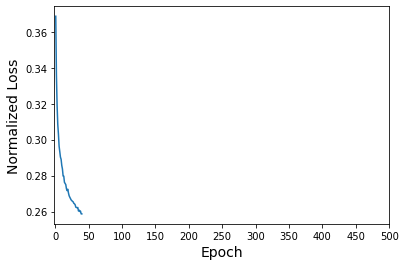

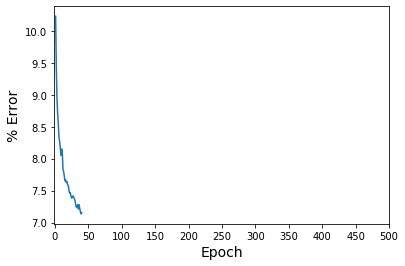

In [117]:
### ACT 25
# plot loss vs epochs, separately plot error vs epochs

#SKIPPING INITIAL LOSS/ERROR, TO HAVE BETTER RESOLUTION

plt.plot(range(1,len(loss_sgd)), loss_sgd[1:])
_ = plt.xlabel('Epoch', fontsize=14)
_ = plt.ylabel('Normalized Loss', fontsize=14)
_ = plt.xticks(np.arange(0,501,50))

plt.show()

plt.plot(range(1,len(error_sgd)), np.asarray(error_sgd[1:])*100)
_ = plt.xlabel('Epoch', fontsize=14)
_ = plt.ylabel('% Error', fontsize=14)
_ = plt.xticks(np.arange(0,501,50))
plt.show()

In [118]:
### ACT 26
# using test data construct a confusion matrix C that is 10x10
# C[i][j] indicates pct digit i was classified as j
# assert that each digit is most likely to be correctly classified

k = 10

y_label_pred = w_sgd.PredictLabels(Xte)

C = np.zeros((k,k))

for y_true,y_pred in zip(y_test,y_label_pred):
    C[y_true][y_pred] += 1

assert np.array_equal(np.argmax(C, axis=1), np.arange(k))

# MNIST
## SGD with One vs. All

In [119]:
### ACT 27
# perform ACT 23-25 with LogisticOvA instead of CrossEntropy
# compare your results, conclude in 1 sentence

starttime = timeit.default_timer()

Loss = LogisticOvA
[w_sgd, loss_sgd, error_sgd] = SGD(Xtr, y_train, Loss, prepare_sgd_handle() )

print("This run took this many seconds :", timeit.default_timer() - starttime)

Epoch: 10  Loss: 0.741  Error: 9.222%
Epoch: 20  Loss: 0.710  Error: 8.733%
Epoch: 30  Loss: 0.695  Error: 8.505%
Epoch: 40  Loss: 0.683  Error: 8.313%
This took this many seconds : 49.17690002600011


In [121]:
# compute test error and loss
test_loss = []
test_err = []

pstr = 'Test  Loss: {0:5.3f}  Error: {1:5.3f}%'

test_loss = w_sgd.Loss(Xte, y_test)
test_err = w_sgd.Error(Xte, y_test)

print(pstr.format(test_loss, 100*test_err))

Test  Loss: 0.678  Error: 8.250%


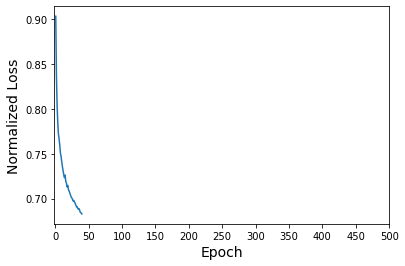

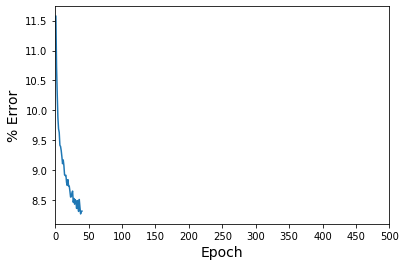

In [122]:
# plot loss vs epochs, separately plot error vs epochs

#SKIPPING INITIAL LOSS/ERROR, TO HAVE BETTER RESOLUTION

plt.plot(range(1,len(loss_sgd)), loss_sgd[1:])
_ = plt.xlabel('Epoch', fontsize=14)
_ = plt.ylabel('Normalized Loss', fontsize=14)
_ = plt.xticks(np.arange(0,501,50))

plt.show()

plt.plot(range(1,len(error_sgd)), np.asarray(error_sgd[1:])*100)
_ = plt.xlabel('Epoch', fontsize=14)
_ = plt.ylabel('% Error', fontsize=14)
_ = plt.xticks(np.arange(0,501,50))
plt.show()

## Comment on results

The results are similar, although CE has slightly better error after 500 epochs.

# 20NEWSGROUPS
## Data Processing

In [123]:
# data processing for 20 newsgroups datasets already done for you.
from sklearn.datasets import fetch_20newsgroups
from collections import Counter

def get_20newsgroups_data():
    newsgroups_train = fetch_20newsgroups(subset='train')
    newsgroups_test  = fetch_20newsgroups(subset='test')
    return newsgroups_train, newsgroups_test

def construct_vocabulary(data, vs):
    vocab = Counter()
    for text in data:
        for word in text.split(' '):
            vocab[word.lower()] += 1
    word2index = dict(vocab.most_common(vs))
    i = 0
    for k in word2index.keys():
        word2index[k] = i
        i += 1
    return word2index

def text_to_vec(data, vocab):
    def norm_rows(M):
        return np.sqrt(np.sum(M * M, axis=1, keepdims=True))
    def project_rows(M, r):
        return M * np.minimum(r / norm_rows(M), 1.0)
    n = len(data)
    d = len(vocab)
    X = np.zeros((n, d))
    i = 0
    for text in data:
        for word in text.split(' '):
            if word.lower() in vocab:
                X[i, vocab[word.lower()]] += 1.0
        i += 1
    # Convert to log-frequencies and normalize to have ||X[i,*]||=1
    X = project_rows(np.log(X + 1.0), 1.0)
    return X

In [124]:
vsize = 1000
train, test = get_20newsgroups_data()
vocab = construct_vocabulary(train.data, vsize)
Xtr = text_to_vec(train.data, vocab)
Xte = text_to_vec(test.data, vocab)
y_train = train.target
y_test = test.target

# 20NEWSGROUPS
## CE

In [126]:
# you will perform the same experiments with this dataset
### ACT 28
# perform ACT 23-27 for the 20newsgroups dataset
# all parameters for training should be the same except:
# we will start with a much larger learning rate eta=1000.0
# and a sphere radius 40.0

### ACT 23
def prepare_sgd_handle():
    h = dict()
    h['pstr'] = 'Epoch: {0:2d}  Loss: {1:5.3f}  Error: {2:5.3f}%'
    h['rad'] = 40.0
    h['replace'] = 0
    
    h['eta0'] = 1000
    h['lr_mode'] = 'sqrt_t'
    
    h['epochs'] = 501
    h['batch_size'] = 1000
 
    h['eps'] = 0.001
    return h


starttime = timeit.default_timer()

Loss = CrossEntropy
[w_sgd, loss_sgd, error_sgd] = SGD(Xtr, y_train, Loss, prepare_sgd_handle() )

print("This run took this many seconds :", timeit.default_timer() - starttime)

Epoch: 10  Loss: 1.308  Error: 31.112%
Epoch: 20  Loss: 1.055  Error: 25.897%
Epoch: 30  Loss: 0.949  Error: 22.901%
Epoch: 40  Loss: 0.921  Error: 21.575%
Epoch: 50  Loss: 0.913  Error: 20.293%
Epoch: 60  Loss: 0.912  Error: 20.011%
Epoch: 70  Loss: 0.910  Error: 19.622%
Epoch: 80  Loss: 0.908  Error: 19.374%
Epoch: 90  Loss: 0.908  Error: 19.038%
Epoch: 100  Loss: 0.908  Error: 19.003%
Epoch: 110  Loss: 0.908  Error: 18.976%
Epoch: 120  Loss: 0.907  Error: 18.932%
Epoch: 130  Loss: 0.908  Error: 19.224%
Epoch: 140  Loss: 0.906  Error: 18.826%
Epoch: 150  Loss: 0.907  Error: 18.791%
Epoch: 160  Loss: 0.907  Error: 18.694%
Epoch: 170  Loss: 0.908  Error: 18.950%
Epoch: 180  Loss: 0.908  Error: 18.844%
Epoch: 190  Loss: 0.907  Error: 18.879%
Epoch: 200  Loss: 0.907  Error: 18.694%
Epoch: 210  Loss: 0.907  Error: 18.870%
Epoch: 220  Loss: 0.907  Error: 18.641%
Epoch: 230  Loss: 0.906  Error: 18.676%
Epoch: 240  Loss: 0.907  Error: 18.782%
Epoch: 250  Loss: 0.906  Error: 18.729%
Epoch: 26

In [127]:
### ACT 24
# compute test error and loss
test_loss = []
test_err = []

pstr = 'Test  Loss: {0:5.3f}  Error: {1:5.3f}%'

test_loss = w_sgd.Loss(Xte, y_test)
test_err = w_sgd.Error(Xte, y_test)

print(pstr.format(test_loss, 100*test_err))

Test  Loss: 1.503  Error: 43.255%


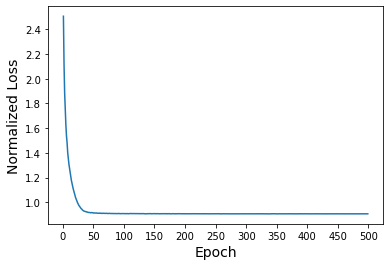

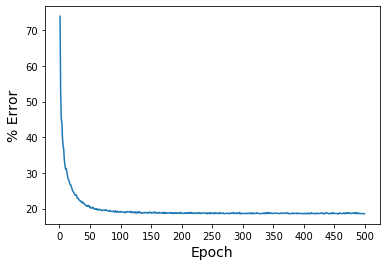

In [128]:
### ACT 25
# plot loss vs epochs, separately plot error vs epochs

#SKIPPING INITIAL LOSS/ERROR, TO HAVE BETTER RESOLUTION

plt.plot(range(1,len(loss_sgd)), loss_sgd[1:])
_ = plt.xlabel('Epoch', fontsize=14)
_ = plt.ylabel('Normalized Loss', fontsize=14)
_ = plt.xticks(np.arange(0,501,50))
plt.show()

plt.plot(range(1,len(error_sgd)), np.asarray(error_sgd[1:])*100)
_ = plt.xlabel('Epoch', fontsize=14)
_ = plt.ylabel('% Error', fontsize=14)
_ = plt.xticks(np.arange(0,501,50))
plt.show()

In [129]:
### ACT 26
# using test data construct a confusion matrix C that is 10x10
# C[i][j] indicates pct digit i was classified as j
# assert that each digit is most likely to be correctly classified

k = 20

y_label_pred = w_sgd.PredictLabels(Xte)

C = np.zeros((k,k))

for y_true,y_pred in zip(y_test,y_label_pred):
    C[y_true][y_pred] += 1

assert np.array_equal(np.argmax(C, axis=1), np.arange(k))

# 20NEWSGROUPS
## Logistic OvA

In [126]:
### ACT 27
# perform ACT 23-25 with LogisticOvA instead of CrossEntropy
# compare your results, conclude in 1 sentence

Loss = LogisticOvA
[w_sgd, loss_sgd, error_sgd] = SGD(Xtr, y_train, Loss, prepare_sgd_handle() )

Epoch: 10  Loss: 2.251  Error: 31.518%
Epoch: 20  Loss: 1.940  Error: 26.657%
Epoch: 30  Loss: 1.851  Error: 24.439%
Epoch: 40  Loss: 1.835  Error: 23.095%
Epoch: 50  Loss: 1.831  Error: 22.556%
Epoch: 60  Loss: 1.827  Error: 22.097%
Epoch: 70  Loss: 1.826  Error: 21.893%
Epoch: 80  Loss: 1.826  Error: 21.955%
Epoch: 90  Loss: 1.827  Error: 21.681%
Epoch: 100  Loss: 1.827  Error: 21.566%
Epoch: 110  Loss: 1.827  Error: 21.778%
Epoch: 120  Loss: 1.828  Error: 21.637%
Epoch: 130  Loss: 1.825  Error: 21.672%
Epoch: 140  Loss: 1.825  Error: 21.557%
Epoch: 150  Loss: 1.825  Error: 21.655%
Epoch: 160  Loss: 1.825  Error: 21.513%
Epoch: 170  Loss: 1.825  Error: 21.495%
Epoch: 180  Loss: 1.826  Error: 21.460%
Epoch: 190  Loss: 1.825  Error: 21.602%
Epoch: 200  Loss: 1.825  Error: 21.416%
Epoch: 210  Loss: 1.826  Error: 21.619%
Epoch: 220  Loss: 1.826  Error: 21.522%
Epoch: 230  Loss: 1.825  Error: 21.672%
Epoch: 240  Loss: 1.825  Error: 21.531%
Epoch: 250  Loss: 1.825  Error: 21.531%
Epoch: 26

In [92]:
# compute test error and loss
test_loss = []
test_err = []

pstr = 'Test  Loss: {0:5.3f}  Error: {1:5.3f}%'

test_loss = w_sgd.Loss(Xte, y_test)
test_err = w_sgd.Error(Xte, y_test)

print(pstr.format(test_loss, 100*test_err))

Test  Loss: 2.451  Error: 43.070%


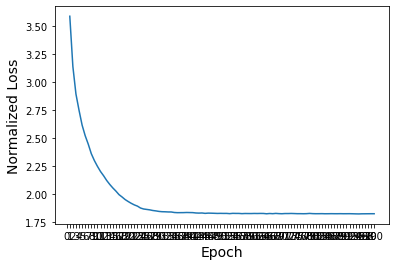

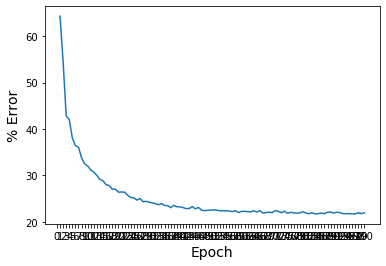

In [93]:
# plot loss vs epochs, separately plot error vs epochs

#SKIPPING INITIAL LOSS/ERROR, TO HAVE BETTER RESOLUTION
plt.plot(range(1,len(loss_sgd)), loss_sgd[1:])
_ = plt.xlabel('Epoch', fontsize=14)
_ = plt.ylabel('Normalized Loss', fontsize=14)
_ = plt.xticks(np.arange(0, len(loss_sgd)))
plt.show()

plt.plot(range(1,len(error_sgd)), np.asarray(error_sgd[1:])*100)
_ = plt.xlabel('Epoch', fontsize=14)
_ = plt.ylabel('% Error', fontsize=14)
_ = plt.xticks(np.arange(0, len(error_sgd)))
plt.show()

In [95]:
### ACT 29
# after training, testing, and plotting make sure to compute the
# row norms of the final parameters (mean and std), and conclude 
# in one sentence whether the results were as you expected

print(np.linalg.norm(w_sgd.W,axis = 1))

[40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40.
 40. 40.]


The norms were all 40, which was the maximum radius of the sphere that we set in the problem. I was expecting the norm to decrease below this threshold, which means our weights are still ending up outside the solution sphere we defined on the problem. Large norms is a sign of over-fitting, which is also justified by the fact that the training error is muc